# Poisson Central Confidence Intervals
 >__Created__:  02 October 2017 Harrison B. Prosper

 > __Updated__: 22 January 2019, adapted for ENHEP 19, Egypt, HBP
 
 Define the *right* and *left* cumulative distribution functions of the Poisson distribution,
 \begin{align*}
      D_R(N, a) & = \sum_{k=N}^\infty \textrm{Poisson}(k, a) = P(N, a),\\
      \textrm{and   } D_L(N, a) & = \sum_{k=0}^N \textrm{Poisson}(k, a) = 1 - P(N+1, a),
 \end{align*}
where $P(N, a)$ is the normalized lower incomplete gamma function
\begin{align*}
P(N, a) & = \int_0^a t^{N-1} e^{-t} \, dt \, / \, \Gamma(N),
\end{align*}
which can be computed with the ROOT function TMath::Gamma(N, a).

In this example, we use the functions $D_R$ and $D_L$ to compute __central confidence intervals__ for the Poisson distribution, which, by construction, have *exact* coverage.  By exact coverage we mean that the coverage probability $f \geq \textrm{CL} \,\, \, \forall a$, where CL is the desired __confidence level__.  We also compute the coverage of the $[N - \sqrt{N},  N + \sqrt{N}]$ intervals, but corrected as follows: $[N - \sqrt{N},  N + \sqrt{N} + \exp(-N)]$. The coverage of the corrected intervals is still *approximate* in that the coverage probability dips below CL for subsets of the mean $a$, but the coverage is considerable better for low values of $a$ than for the uncorrected intervals.

We use a confidence level of CL = 0.683.


In [1]:
import os, sys
import ROOT
from math import sqrt, exp
%jsroot off
%run "setStyle.ipynb"

Welcome to JupyROOT 6.14/06


In [2]:
ran  = ROOT.TRandom3()
Nmax = 175    # maximum count for which confidence intervals are to be computed
amin =   0.0  # minimum mean value
amax =  25.0  # maximum mean value (should << Nmax)
Nexp = 500    # number of experiments, each with a different mean
Nrep = 1000   # number of repeated experiments
CL   = 0.683  # confidence level

#### Compute central interval

In [3]:
def computeCentralIntervals(N, p=0.683):
    from math import sqrt
    def fR(x):
        # right cumulative distribution function
        DR = ROOT.TMath.Gamma(N, x[0])
        return DR - (1 - p)/2
    
    def fL(x):
        # left cumulative distribution function
        DL = 1 - ROOT.TMath.Gamma(N + 1, x[0])
        return DL - (1 - p)/2

    def findLimit(name, func, smin, smax):
        f  = ROOT.TF1(name, func, smin, smax)
        wf = ROOT.Math.WrappedTF1(f)
        rf = ROOT.Math.BrentRootFinder()
        rf.SetFunction(wf, smin, smax)
        ItWorked = rf.Solve()
        if ItWorked:
            return rf.Root()
        else:
            sys.exit("*** rootfinder failed")
        
    # find aL
    if N == 0:
        aL = 0.0
    else:
        smin = max(0.01, N - 2*sqrt(N))
        smax = N
        aL = findLimit('aL', fR, smin, smax)
        
    # find aU
    smin = N 
    smax = N + 2*sqrt(N) + 5
    aU = findLimit('aU', fL, smin, smax)

    return (aL, aU)

#### Compute all central intervals for $N = 0 \textrm{ to } N_\textrm{max}$

In [4]:
central = [computeCentralIntervals(N, CL) for N in xrange(Nmax)]
rootN0  = [(N - sqrt(N), N + sqrt(N)) for N in range(Nmax)]
rootNC  = [(N - sqrt(N), N + sqrt(N)+exp(-N)) for N in range(Nmax)]

#### Compute coverage associated with different mean values $a$ 

  * *Monte Carlo Simulation* For each value of $a$, repeat the associated experiment $N_\textrm{exp}$ times and count how often the statement $a \in [a_L, a_U]$ is true. 
  
  * *Direct Calcuation* For each value of $a$, use the computed intervals to find the central interval $[N_L, N_U]$ in the space of observations and compute the coverage $p = D_R(N_L, a) - D_R(N_U+1, a)$.

In [5]:
def computeCoverage(intervals, amin, amax, nexp, ran=None, n=1000): 
    from math import sqrt
    
    bySimulation = ran != None
    
    step = (amax - amin) / nexp
    coverage = []
    for j in xrange(nexp):
        # mean value
        a = (j+0.5)*step
        #if j % 50 == 0:
        #    print "experiment %5d with mean %10.3f" % (j, a)
            
        if bySimulation:
            # compute coverage by simulation
            # repeat the same experiment n times and
            # count number of true statements
            k = 0
            for i in xrange(n):
                N = ran.Poisson(a)
                if N < len(intervals):
                    aL, aU = intervals[N]
                    if (aL < a) and (a < aU):
                        k += 1
                else:
                    print "** no interval for N = %d" % N
        
            # compute coverage fraction (i.e., fraction of true statements)
            p  = float(k)/n
    
            # since we have k true statements our of n, this is a binomial
            # problem with variance n*p*(1-p). Therefore, a rough estimate
            # of the uncertainty in p is
            dp = sqrt(n*p*(1-p))/n
        else:
            # compute coverage exactly
            NL = None
            for N in xrange(len(intervals)):
                aL, aU = intervals[N]
                if (aL < a) and (a < aU):
                    NL = N
                    break
            NU = None
            for N in xrange(NL, len(intervals)+1):
                aL, aU = intervals[N]
                if (aL < a) and (a < aU):
                    NU = N
                else:
                    break
            if NL == None:
                sys.exit("** can't find NL")
            if NU == None:
                sys.exit("** can't find NU")
            p = ROOT.TMath.Gamma(NL, a) - ROOT.TMath.Gamma(NU+1, a)
            dp= 0.0
            #print "%10.3f [%d, %d] = %10.3f" % (a, NL, NU, p)
        coverage.append((a, p, dp))
        
    return coverage

In [6]:
# compute coverage by simulation
coverageSim = computeCoverage(central, amin, amax, Nexp, ran, Nrep)
print "number of experiments: %d" % len(coverageSim)

number of experiments: 500


In [7]:
# compute coverage exactly
coverageExact = computeCoverage(central, amin, amax, Nexp)
print "number of experiments: %d" % len(coverageExact)

number of experiments: 500


In [8]:
# compute coverage of rootN0 intervals exactly
coverageRootN0 = computeCoverage(rootN0, amin, amax, Nexp)
print "number of experiments: %d" % len(coverageRootN0)

number of experiments: 500


In [9]:
# compute coverage of rootN intervals exactly
coverageRootNC = computeCoverage(rootNC, amin, amax, Nexp)
print "number of experiments: %d" % len(coverageRootNC)

number of experiments: 500


### Plot coverage vs. mean count $a$

In [10]:
def plotCoverage(coverage, amin, amax, CL=0.683):
    from array import array
    
    # create a graph of coverage vs. mean
    nexp = len(coverage)
    a = array('d')
    p = array('d')
    for x, q, dq in coverage:
        a.append(x)
        p.append(q)
        
    g = ROOT.TGraph(nexp, a, p)
    g.SetLineWidth(2)
    g.SetLineColor(ROOT.kBlue)
    g.GetXaxis().SetLimits(amin, amax)
    g.GetXaxis().SetTitle('Poisson mean #font[12]{s}')
    g.GetYaxis().SetTitle('#font[12]{f} = Pr( #font[12]{s} #in '\
                          '[#font[12]{l}(#font[12]{n}), #font[12]{u}(#font[12]{n})] )    ')
    g.GetHistogram().SetAxisRange(0, 1, "Y")
    
    a[0], a[1] = amin, amax
    p[0] = p[1]= CL
    hline = ROOT.TGraph(2, a, p)
    hline.GetXaxis().SetLimits(amin, amax)
    hline.GetHistogram().SetAxisRange(0, 1, "Y")
    hline.SetLineWidth(2)
    hline.SetLineColor(ROOT.kRed)
    
    return (g, hline)

Info in <TCanvas::Print>: png file ./fig_coverage_Poisson_intervals.png has been created


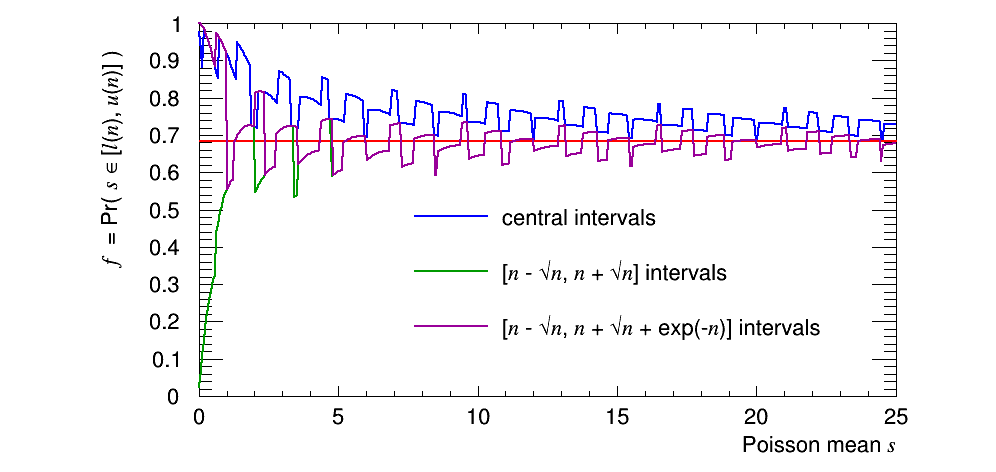

In [11]:
setStyle()
gsim,   hsim   = plotCoverage(coverageSim,   amin, amax, CL)
gexact, hexact = plotCoverage(coverageExact, amin, amax, CL)
grootN0,hrootN0= plotCoverage(coverageRootN0,amin, amax, CL)
grootNC,hrootNC= plotCoverage(coverageRootNC,amin, amax, CL)
grootN0.SetLineColor(ROOT.kGreen+2)
grootNC.SetLineColor(ROOT.kMagenta+2)

c = ROOT.TCanvas("fig_coverage_Poisson_intervals", "coverage", 1000, 500);
gexact.Draw('al')
hexact.Draw('lsame')
grootN0.Draw('lsame')
grootNC.Draw('lsame')
lg = mklegend(0.4, 0.25, 0.42, 0.35)
lg.AddEntry(gexact, 'central intervals','l')
lg.AddEntry(grootN0, 
            '[#font[12]{n} - #surd#font[12]{n}, '\
            '#font[12]{n} + #surd#font[12]{n}] intervals', 'l')
lg.AddEntry(grootNC, 
            '[#font[12]{n} - #surd#font[12]{n}, '\
            '#font[12]{n} + #surd#font[12]{n} + exp(-#font[12]{n})] intervals', 'l')
lg.Draw()
c.Draw()
c.SaveAs(".png")